# Leakage detection for loop randomization

This notebook focuses on leakage detection methods.
Again, the scope is limited to first order leakage.

We will see that the methods introduced in [Key recovery](./3_key_recovery_loop.ipynb) can also be used to "detect leakage" without performing a real attack to recover the secret key.

When thinking about side-channel resistant implementations it is often not sufficient to achieve a resistance against key recovery in the classical DPA/CPA scenario. For instance template attacks are powerful weapons to break implementations. But, all techniques require that a secret "leaks" by a certain extend. Again, talking about template attacks, the first step there is to detect points-of-interest. Without them it is not possible to create good templates.

We know our implementation and have full control over the processed data. So, there is no need to assume an unknown fixed key and attack with varying input. We can _directly_ "attack" the key. Therefore we proceed as following:

1. Record traces with random key and random input.
2. Use the techniques from [Key recovery](./3_key_recovery_loop.ipynb) to see how "leaky" the key behaves.

In [1]:
%load_ext autoreload
%autoreload 2

import random

import lascar
import matplotlib.pyplot as plt
import numpy as np

import datasets
import leakage_detection_loop
from leakage_detection_loop import njit

lascar.logger.setLevel(lascar.logging.CRITICAL)
plt.rcParams['figure.figsize'] = [15.0, 4.0]
plt.rcParams['figure.dpi'] = 140


## Example: CWARM loop4

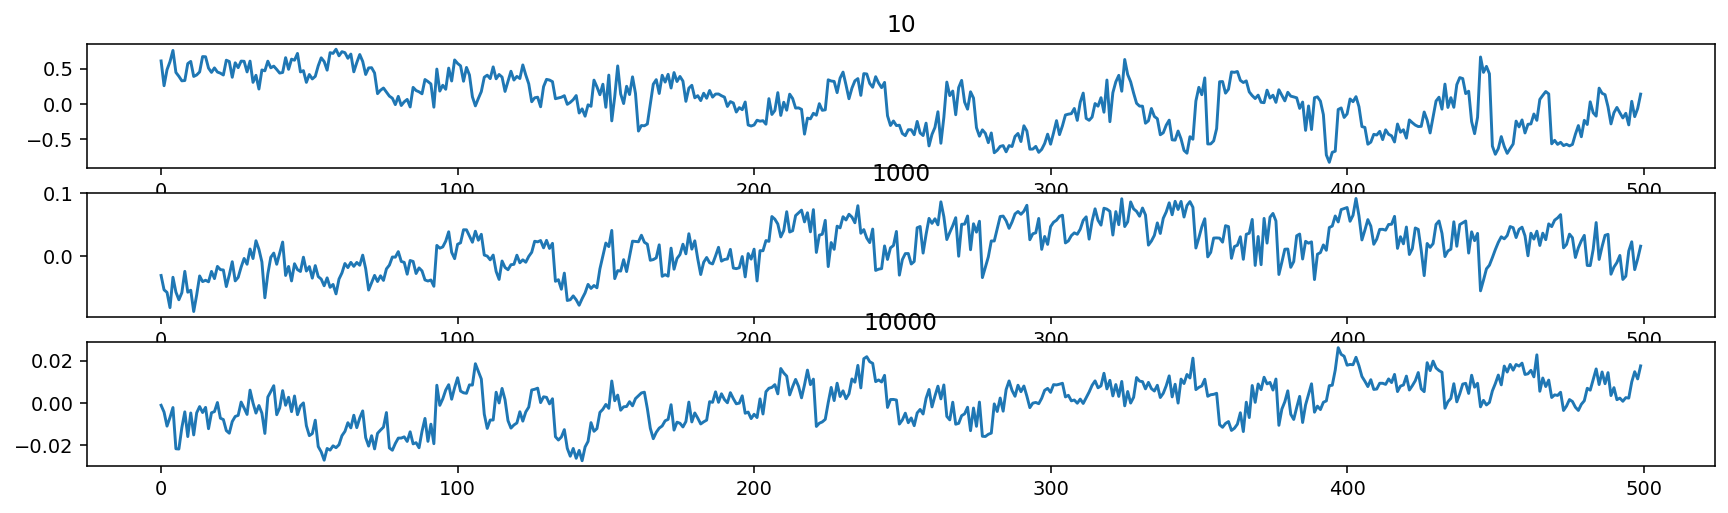

In [2]:
_, axes = plt.subplots(3, 1)
for i, amount in enumerate((10, 1_000, 10_000)):
    cpa = leakage_detection_loop.cpa_full(
        dataset=datasets.dataset(f"cwarm_loop4_randomkey_randominput")[:amount],
        selection_function=lambda value, guess: lascar.hamming(
            lascar.tools.aes.sbox[value["input"][2] ^ value["key"][2]]
        ),
        guess_range=range(1),
    )
    axes[i].plot(cpa)
    axes[i].set_title(amount)

plt.show()


We see that with an increasing number of traces two things happen:
- The absolute maximum of the correlation decreases
- The leakage becomes "more visible"

## A Metric for Leakage

### Requirements

The plots above give a clear view: 
Leakage is higher whenever a peak is better to see and the noise floor is lower.
But it is not obvious (at least for the author) how to put this into a good formula.

Let us put the requirements for a leakage metric $m(\mathcal T)$ for a set of traces $\mathcal T$:

- r1: The leakage metric $m(\mathcal T)$ shall be monotonously increasing with the number of traces processed. <br/>
  Formally: Given two subsets $\mathcal I, J \subseteq \mathcal T$ with $|I| \leq |J|$: $m(\mathcal I) \leq m(\mathcal J)$. 
- r2: Assume a fixed trace source and a fixed leakage model and an implementation with different security levels. 
  If the key of security level $A$ can be revealed after $|\mathcal T|$ traces applying a key recovery technique and the key of security level $B$ after $|\mathcal S|$ traces then their leakage metric shall be equal: $m_A(\mathcal T) = m_B(\mathcal S)$.
- r3: The metric shall be asymptotic aspiring a limit.

### Disclaimer

The author has tried several different functions as metric. 
Although each of the following ideas has its justification none of them fulfilled the requirements above very well:

- Looking at one of the graphs above the author wanted to bisect the data into the "peaks" and the "noise floor".
  The following functions have been tried:
  - Normalize to [0, 1] and count the number of peaks.
  - Take the height of the highest peak divided by the standard deviation of the correlation without the peaks.
  - Use `scipy.signal.find_peaks` or `scipy.fft` to detect peaks.

### A valid proposal of a metric

The following metric is the best one the author was able to find:

1. Capture traces with random key and random input. <br/>
   (To be adjusted accordingly if another number of values is processed.)
2. Calculate the pointwise pearson correlation.
3. Define the _cpa leakage rate_ as the absolute maximum of the correlation with the correct guess divided by the standard deviation of the correlation with random values.

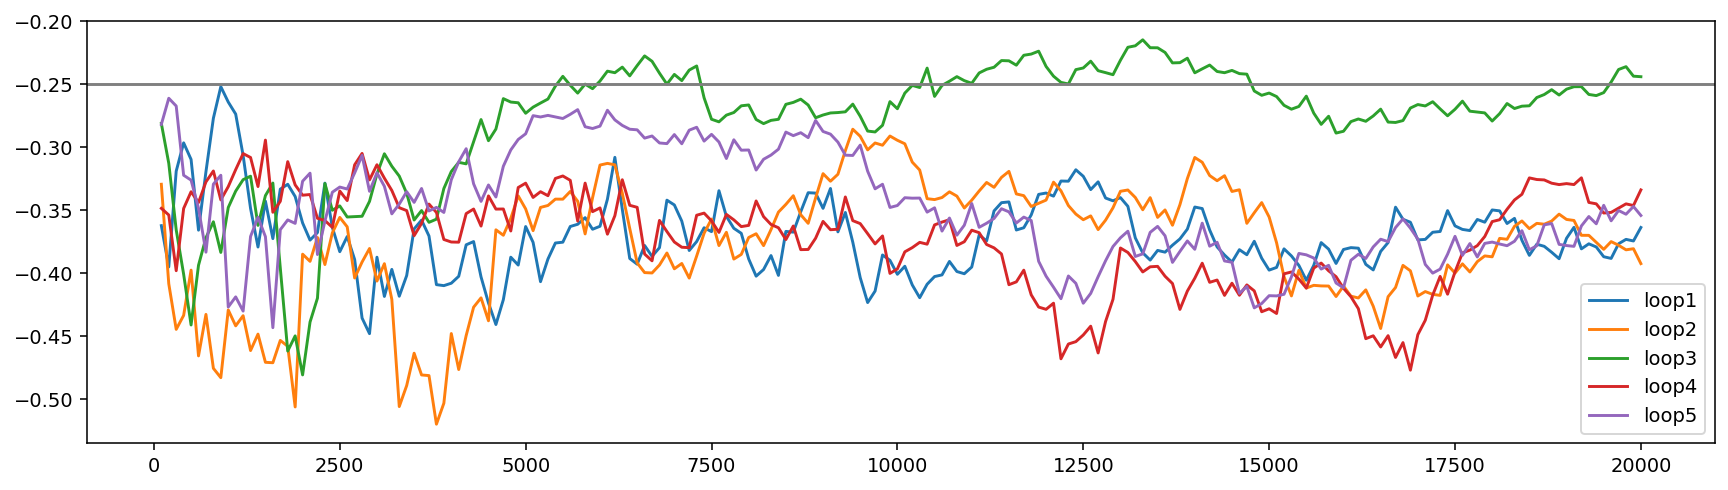

In [3]:
for name in ("loop1", "loop2", "loop3", "loop4", "loop5"):
    clr = leakage_detection_loop.cpa_leakage_rate(
        dataset=datasets.dataset(f"cwarm_{name}_randomkey_randominput"),
        selection_function=njit()(
            lambda value: lascar.hamming(lascar.tools.aes.sbox[value["input"][2] ^ value["key"][2]])
        ),
    )
    plt.plot(*zip(*clr), label=name)

plt.axhline(-0.25, color="gray")
plt.legend()
plt.show()


### Notes

- The number of random correlation guesses is set to a fixed number.
  A higher number will give a more robust trace but on cost of computational complexity.

## Leaky intermediates

[]

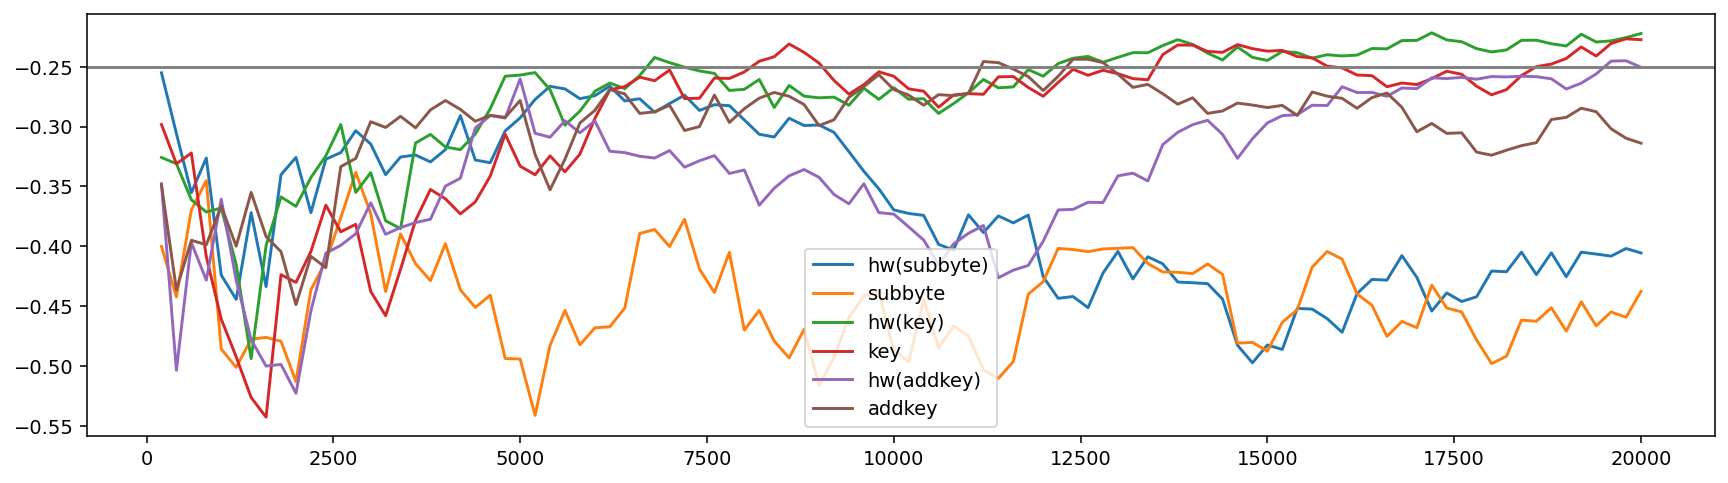

In [4]:
clrs = leakage_detection_loop.cpa_leakage_rates(
    dataset=datasets.dataset(f"cwarm_loop5_randomkey_randominput")[:20_000],
    selection_functions={
        "hw(subbyte)": lambda value: lascar.hamming(lascar.tools.aes.sbox[value["input"][2] ^ value["key"][2]]),
        "subbyte": lambda value: lascar.tools.aes.sbox[value["input"][2] ^ value["key"][2]],
        "hw(key)": lambda value: lascar.hamming(value["key"][2]),
        "key": lambda value: value["key"][2],
        "hw(addkey)": lambda value: lascar.hamming(value["key"][2] ^ value["input"][2]),
        "addkey": lambda value: value["key"][2] ^ value["input"][2],
    },
)

for name, clr in clrs:
    plt.plot(*zip(*clr), label=name)

plt.axhline(-0.25, color="gray")
plt.legend()
plt.plot()
